# Classification on OIA ODIR dataset
Ocular Disease Intelligent Recognition (ODIR),organized by National Institute of Health Data Science at Peking University (NIHDS-PKU) and  Institute of Artificial Intelligence at Peking University (IAI-PKU), co-organized by Shanggong Medical Technology Co. Ltd. (SG) and Advanced Institute of Information Technology at Peking University (AIIT-PKU). 
https://odir2019.grand-challenge.org/dataset/ 



## Dataset details :
5,000 structured desensitized ophthalmologic image set of patient's age, sex, binocular ***color fundus photos*** and doctors' diagnostic keywords. 

Diseases Covered: Normal (N), Diabetes (D), Glaucoma (G), AMD (A) and Hypertension (H). 

Diseases Droped:Cataract (C), Myopia (M), Opacity (O)

# Import Files & Libraries

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, CategoricalHinge
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [ ]:
import datetime
from tensorboard.plugins.hparams import api as hp

In [ ]:
training_annotations=pd.read_excel("/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/oia_odir_dataset/Training Set/Annotation/training.xlsx")
test_annotations=pd.read_excel("/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/oia_odir_dataset/Onsite_Test_Set/Annotation/on-site-test.xlsx")

# Import Data

In [ ]:
training_annotations.drop(['Patient Sex','Patient Age','Left-Diagnostic Keywords','Right-Diagnostic Keywords'],axis=1,inplace=True)
test_annotations.drop(['Patient Sex','Patient Age','Left-Diagnostic Keywords','Right-Diagnostic Keywords'],axis=1,inplace=True)

In [ ]:
training_annotations

,ID,Left-Fundus,Right-Fundus,N,D,G,C,A,H,M,O
0,0,0_left.jpg,0_right.jpg,0,0,0,1,0,0,0,0
1,1,1_left.jpg,1_right.jpg,1,0,0,0,0,0,0,0
2,2,2_left.jpg,2_right.jpg,0,1,0,0,0,0,0,1
3,3,3_left.jpg,3_right.jpg,0,0,0,0,0,0,0,1
4,4,4_left.jpg,4_right.jpg,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,4686_left.jpg,4686_right.jpg,0,1,0,0,0,0,0,0
3496,4688,4688_left.jpg,4688_right.jpg,0,1,0,0,0,0,0,0
3497,4689,4689_left.jpg,4689_right.jpg,0,1,0,0,0,0,0,0
3498,4690,4690_left.jpg,4690_right.jpg,0,1,0,0,0,0,0,0


In [ ]:
total_train=training_annotations
total_train=total_train.append(training_annotations)
total_train=total_train.reset_index() # make index 0 - 6999

total_test=test_annotations
total_test=total_test.append(test_annotations)
total_test=total_test.reset_index() # make index 0 -999

In [ ]:
total_train['Left-Fundus'][3500:6999]=total_train['Right-Fundus'][3500:6999]
total_train[6999:7000]['Left-Fundus']=total_train[6999:7000]['Right-Fundus'] # to make 6999 change from left to rgt
total_train.drop(['Right-Fundus'],axis=1,inplace=True)
total_train.drop(['index'],axis=1,inplace=True)
total_train=total_train.rename(columns={"Left-Fundus": "Fundus"})

# Test dataframe
total_test['Left-Fundus'][1000:1999]=total_test['Right-Fundus'][1000:1999]
total_test[1000:1999]['Left-Fundus']=total_test[1000:1999]['Right-Fundus'] # to make change from left to rgt
# drop all labels
total_test.drop(['Right-Fundus','index','N','D','G','A','H','C','M','O'],axis=1,inplace=True)
total_test=total_test.rename(columns={"Left-Fundus": "Fundus"})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/u

In [ ]:
total_train

,ID,Fundus,N,D,G,C,A,H,M,O
0,0,0_left.jpg,0,0,0,1,0,0,0,0
1,1,1_left.jpg,1,0,0,0,0,0,0,0
2,2,2_left.jpg,0,1,0,0,0,0,0,1
3,3,3_left.jpg,0,0,0,0,0,0,0,1
4,4,4_left.jpg,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
6995,4686,4686_right.jpg,0,1,0,0,0,0,0,0
6996,4688,4688_right.jpg,0,1,0,0,0,0,0,0
6997,4689,4689_right.jpg,0,1,0,0,0,0,0,0
6998,4690,4690_right.jpg,0,1,0,0,0,0,0,0


In [ ]:
total_test

,ID,Fundus
0,198,198_left.jpg
1,663,663_left.jpg
2,1025,1025_left.jpg
3,1139,1139_left.jpg
4,1141,1141_left.jpg
...,...,...
1995,4995,4995_right.jpg
1996,4996,4996_right.jpg
1997,4997,4997_right.jpg
1998,4998,4998_right.jpg


# EDA + Conversion to multi - class problem

In [ ]:
sum_column = total_train['N']+total_train['A']+total_train['D']+total_train['G']+total_train['H']
sum_column

0       0
1       1
2       1
3       0
4       1
       ..
6995    1
6996    1
6997    1
6998    1
6999    2
Length: 7000, dtype: int64

In [ ]:
# No of images making problem multi label
index_multi_labeled=[]

for i in range(0,len(sum_column)):
  if sum_column[i]!=1:
    index_multi_labeled.append(i)
print(len(index_multi_labeled))
print(index_multi_labeled)

1964
[0, 3, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 24, 25, 29, 31, 33, 34, 35, 36, 38, 39, 40, 42, 43, 51, 52, 56, 57, 58, 59, 60, 61, 63, 65, 66, 68, 69, 70, 71, 73, 75, 76, 78, 80, 82, 83, 85, 88, 91, 92, 95, 97, 98, 99, 100, 101, 103, 104, 105, 106, 109, 110, 112, 114, 115, 117, 119, 120, 122, 124, 125, 127, 128, 129, 131, 132, 134, 135, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 153, 154, 155, 156, 165, 166, 170, 172, 173, 174, 176, 178, 180, 181, 182, 183, 185, 187, 189, 190, 192, 194, 196, 197, 199, 203, 204, 207, 211, 213, 214, 217, 218, 219, 221, 225, 226, 227, 231, 232, 235, 236, 237, 238, 239, 240, 241, 243, 244, 245, 246, 247, 251, 252, 253, 254, 255, 257, 258, 260, 268, 270, 272, 274, 275, 276, 277, 282, 284, 285, 286, 289, 292, 293, 294, 295, 296, 297, 300, 301, 302, 304, 305, 306, 309, 310, 312, 314, 315, 316, 317, 321, 324, 325, 328, 329, 330, 331, 332, 334, 335, 336, 338, 342, 343, 345, 346, 348, 349, 350, 351, 352, 353, 355, 356, 361, 362, 363,

In [ ]:
# Drop Cataract (C), Myopia (M) & Opacity (O)
train=total_train.drop(['C','M','O'],axis=1)

# drop multi labeled images
train.drop(index_multi_labeled,inplace=True)

In [ ]:
LABELS = train.columns[2:]
def build_label(row):
  return ",".join([LABELS[idx] for idx, val in enumerate(row[2:]) if val == 1])
        
train.apply(lambda x: build_label(x), axis=1).value_counts()

print(LABELS)

def build_label_list(row):
  return [LABELS[idx] for idx, val in enumerate(row[2:]) if val == 1]
        
train["label"] = train.apply(lambda x: build_label_list(x), axis=1)

Index(['N', 'D', 'G', 'A', 'H', 'label'], dtype='object')


No of images in each class

In [ ]:
train.sum()

ID                                                 13369090
Fundus    1_left.jpg2_left.jpg4_left.jpg5_left.jpg6_left...
N                                                      2280
D                                                      2070
G                                                       328
A                                                       266
H                                                        92
label     [N, D, D, D, D, D, N, D, D, H, D, D, H, G, H, ...
dtype: object

# Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,validation_split=0.1,
    horizontal_flip=True,preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function = preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train,directory="/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/oia_odir_dataset/Training Set/Images",
    batch_size=32,color_mode="rgb",subset='training',target_size=(224, 224),
    x_col='Fundus',class_mode="categorical",y_col="label") 

"""
train_generator = train_datagen.flow_from_dataframe(
    train,directory="/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/oia_odir_dataset/Training Set/Images",
    batch_size=32,color_mode="rgb",subset='training',
    x_col='Fundus',class_mode='multi_output',target_size=(224, 224),y_col=['N','D','G','A','H']) 
#earlier class mode was multi-output "raw"
"""

Found 4533 validated image filenames belonging to 5 classes.


'\ntrain_generator = train_datagen.flow_from_dataframe(\n    train,directory="/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/oia_odir_dataset/Training Set/Images",\n    batch_size=32,color_mode="rgb",subset=\'training\',\n    x_col=\'Fundus\',class_mode=\'multi_output\',target_size=(224, 224),y_col=[\'N\',\'D\',\'G\',\'A\',\'H\']) \n#earlier class mode was multi-output "raw"\n'

In [ ]:
validation_generator= train_datagen.flow_from_dataframe(train,batch_size=32,
                                                  directory="/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/oia_odir_dataset/Training Set/Images",target_size=(224, 224),
                                                  x_col='Fundus',class_mode="categorical",y_col="label",subset='validation') 

"""
validation_generator= train_datagen.flow_from_dataframe(train,batch_size=32,
                                                  directory="/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/oia_odir_dataset/Training Set/Images",target_size=(224, 224),
                                                  x_col='Fundus',y_col=['N','D','G','A','H'],class_mode='multi_output',subset='validation')
"""

Found 503 validated image filenames belonging to 5 classes.


'\nvalidation_generator= train_datagen.flow_from_dataframe(train,batch_size=32,\n                                                  directory="/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/oia_odir_dataset/Training Set/Images",target_size=(224, 224),\n                                                  x_col=\'Fundus\',y_col=[\'N\',\'D\',\'G\',\'A\',\'H\'],class_mode=\'multi_output\',subset=\'validation\')\n'

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    total_test,directory="/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/oia_odir_dataset/Onsite_Test_Set/Images",target_size=(224, 224),
    x_col='Fundus',batch_size=32,class_mode=None)

Found 2000 validated image filenames.


# Efficient Net B0 Model

In [ ]:
IMG_SHAPE = (224, 224,3)

base_model=EfficientNetB0(input_shape=IMG_SHAPE,include_top=False, weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False  

x = base_model.output
x=Flatten()(x)

predictions = Dense(5, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
____________________________________________________________________________________________

In [ ]:
base_learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=base_learning_rate), loss=tensorflow.keras.losses.CategoricalCrossentropy(), metrics = [tensorflow.keras.metrics.Accuracy()])

In [ ]:
ckpt_filename= "/content/gdrive/My Drive/Colab Notebooks/DerbiHackathon_ODIR_EfficientNetB0_Multiclass.hdf5"
checkpoint = ModelCheckpoint(filepath=ckpt_filename, save_best_only=True, verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose = 1)

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=15, callbacks=[checkpoint,early_stop,lr_reduce]) 

Epoch 1/15
142/142 [==============================] - 563s 4s/step - loss: 1.1698 - accuracy: 0.0000e+00 - val_loss: 1.7479 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.74791, saving model to /content/gdrive/My Drive/Colab Notebooks/DerbiHackathon_ODIR_EfficientNetB0_Multiclass.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
142/142 [==============================] - 558s 4s/step - loss: 1.2053 - accuracy: 0.0000e+00 - val_loss: 1.9478 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 1.74791
Epoch 3/15
142/142 [==============================] - 564s 4s/step - loss: 1.1454 - accuracy: 0.0000e+00 - val_loss: 1.5972 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss improved from 1.74791 to 1.59718, saving model to /content/gdrive/My Drive/Colab Notebooks/DerbiHackathon_ODIR_EfficientNetB0_Multiclass.hdf5
Epoch 4/15
142/142 [==============================] - 554s 4s/step - loss: 1.1644 - accuracy: 0.0000e+00 - val_loss: 1.6256 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 1.59718
Epoch 5/15
142/142 [==============================] - 558s 4s/step - loss: 1.1869 - accuracy: 0.0000e+00 - val_loss: 1.4632 - val_accuracy: 0.0000e+00

Epoch 00005: val_loss improved from 1.59718 to 1.46315, saving model to /content/gdrive/My Drive/Colab Notebooks/DerbiHackatho

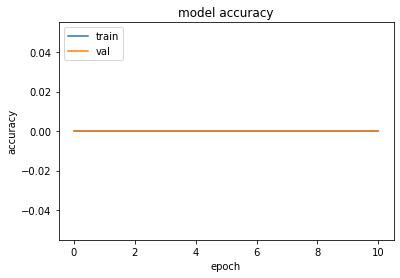

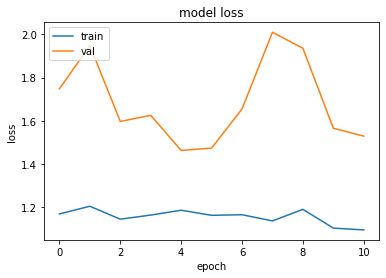

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

plot_acc(history)
plt.show()
plot_loss(history)
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc_curves(y_true, y_pred, num_classes, class_labels):
    
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_test = lb.transform(y_true)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    for i in range(num_classes):
        fig, c_ax = plt.subplots(1,1, figsize = (6, 4))
        c_ax.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.4f})'
                 ''.format(class_labels[i], roc_auc[i]))
        c_ax.set_xlabel('False Positive Rate')
        c_ax.set_ylabel('True Positive Rate')
        c_ax.set_title('ROC curve of class {0}'.format(class_labels[i]))
        c_ax.legend(loc="lower right")
        plt.show()
    return roc_auc_score(y_test, y_pred)

In [ ]:
score = model.evaluate(test_generator)
print('\nTest set accuracy:', score[1], '\n')
    
y_true = np.array(test_generator.labels)
y_pred = model.predict(test_generator, verbose = 1)
y_pred_classes = np.argmax(y_pred,axis = 1)
class_labels = list(test_generator.class_indices.keys())   
    
print('\n', sklearn.metrics.classification_report(y_true, y_pred_classes, target_names=class_labels), sep='')
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = class_labels)
plt.show()
print("ROC AUC score:", plot_roc_curves(y_true, y_pred,5, class_labels))

63/63 [==============================] - 128s 2s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00

Test set accuracy: 0.0 



AttributeError: ignored

#  OLD
## Efficient Net

In [ ]:
ckpt_filename= "/content/gdrive/My Drive/Colab Notebooks/DerbiHackathonEfficientNetB0.hdf5"
checkpoint = ModelCheckpoint(filepath=ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, mode='min', verbose = 1)

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=15, callbacks=[checkpoint,early_stop,lr_reduce]) 

Epoch 1/15
197/197 [==============================] - 5122s 26s/step - loss: 0.8536 - accuracy: 0.1477 - val_loss: 1.6588 - val_accuracy: 0.0100

Epoch 00001: val_loss improved from inf to 1.65885, saving model to /content/gdrive/My Drive/Colab Notebooks/DerbiHackathonEfficientNetB0.hdf5
Epoch 2/15
197/197 [==============================] - 1865s 9s/step - loss: 0.8529 - accuracy: 0.1445 - val_loss: 1.9581 - val_accuracy: 0.0100

Epoch 00002: val_loss did not improve from 1.65885
Epoch 3/15
197/197 [==============================] - 1868s 9s/step - loss: 0.8529 - accuracy: 0.1445 - val_loss: 1.9793 - val_accuracy: 0.0100

Epoch 00003: val_loss did not improve from 1.65885

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/15
197/197 [==============================] - 1864s 9s/step - loss: 0.8529 - accuracy: 0.1445 - val_loss: 1.9795 - val_accuracy: 0.0100

Epoch 00004: val_loss did not improve from 1.65885
Epoch 00004: early stopping


In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    

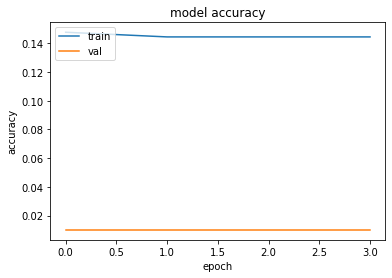

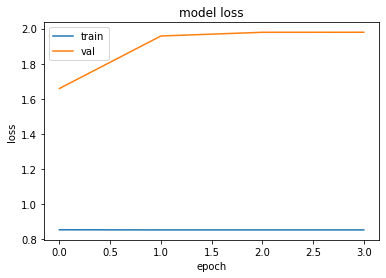

In [ ]:
plot_acc(history)
plt.show()
plot_loss(history)
plt.show()